# Explore Covid-19 scholarly articles (CORD-19) using NLP and unsupervised machine learning



### Dataset Description

The COVID-19 Open Research Dataset (CORD-19) is a growing resource of scientific papers on COVID-19 and related historical coronavirus research. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. The corpus is updated regularly as new research is published in peer-reviewed publications and archival services like bioRxiv, medRxiv, and others.

The dataset contains all COVID-19 and coronavirus-related research (e.g. SARS, MERS, etc.) from the following sources:

- PubMed's PMC open access corpus using this query (COVID-19 and coronavirus research)
- Additional COVID-19 research articles from a corpus maintained by the WHO
- bioRxiv and medRxiv pre-prints using the same query as PMC (COVID-19 and coronavirus research)

It also includes a comprehensive metadata file of more than 50,000 coronavirus and COVID-19 research articles with links to PubMed, Microsoft Academic and the WHO COVID-19 database of publications.

References:   
COVID-19 Open Research Dataset (CORD-19). 2020. Version 2020-03-13. Retrieved from
https://www.semanticscholar.org/cord19
https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=Kaggle \
https://www.kaggle.com/maria17/cord-19-explore-drugs-being-developed/data 



### Objective

The aim of this notebook is to provide resources and insights, through data science, to answer the following questions:  

*What do we know about vaccines and therapeutics? What has been published concerning research and development and evaluation efforts of vaccines and therapeutics?*


### Strategy adopted

This notebook make use of NLP, text mining, dataframe processing and visualization resources.

## Import necessary libraries

In [ ]:
# !pip install ipywidgets matplotlib pandas spacy tqdm
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz

In [ ]:
%%bash -e
if ! [[ -f ./xyz2mol.py ]]; then
  wget https://raw.githubusercontent.com/jensengroup/xyz2mol/master/xyz2mol.py
fi

In [ ]:
!pip install py3Dmol
!pip install -U chembl_webresource_client
import sys
!conda install --yes --prefix {sys.prefix} -c rdkit rdkit

In [1]:
import glob
import json
import pandas as pd
import pickle
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from tqdm import tqdm
import en_ner_bc5cdr_md
import os
from collections import Counter
import matplotlib.pyplot as plt
from chembl_webresource_client.new_client import new_client
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import py3Dmol # Amazing library for 3D visualization
from rdkit import Chem
from rdkit.Chem import AllChem
from ipywidgets import interact, interactive, fixed
from IPython.display import Image
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.cluster import KMeans
import gc

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/spacy/util.py:271: UserWarning: [W031] Model 'en_ner_bc5cdr_md' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# Load and Clean Data
Load the data and perform the necessary processing.

## Load Metadata

In [2]:
def doi_to_url(doi):
    if isinstance(doi, float):
        return None
    elif doi.startswith('http'):
        return str(doi)
    elif doi.startswith('doi'):
        return 'https://' + str(doi)
    else:
        return 'https://doi.org/' + str(doi)

In [4]:
df_meta = pd.read_csv('/Users/admin/Desktop/Drugs being developed for Covid-19/2020-06-17/metadata.csv')
df_meta['url'] = df_meta.doi.apply(doi_to_url)
df_meta.head(3)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,13,14,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636.0,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://doi.org/10.1186/1471-2334-1-6,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967.0,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://doi.org/10.1186/rr14,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972.0,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://doi.org/10.1186/rr19,NaN


## Load JSON Data

In [5]:
data_path = '/Users/admin/Desktop/Drugs being developed for Covid-19/2020-06-17/document_parses/pdf_json'
json_files = glob.glob(f'{data_path}/**/**/*.json', recursive=True)
len(json_files)

74949

In [6]:
def to_covid_json(json_files):
    jsonl = []
    for file_name in tqdm(json_files):
        row = {"doc_id": None, "title": None, "abstract": None, "body": None}

        with open(file_name) as json_data:
            data = json.load(json_data)

            row['doc_id'] = data['paper_id']
            row['title'] = data['metadata']['title']
            
            abstract_list = [abst['text'] for abst in data['abstract']]
            abstract = "\n".join(abstract_list)
            row['abstract'] = abstract

            # And lastly the body of the text. 
            body_list = [bt['text'] for bt in data['body_text']]
            body = "\n".join(body_list)
            row['body'] = body
            
        jsonl.append(row)
    
    return jsonl
    

def get_data():
    try:
        with open('df_cache.pickle', 'rb') as f:
            df = pickle.load(f)
    except FileNotFoundError:
        df = pd.DataFrame(to_covid_json(json_files))
        with open('df_cache.pickle', 'wb') as f:
            pickle.dump(df, f)
    return df

df = get_data()
print(df.shape)
df.head(3)

(74949, 4)


,doc_id,title,abstract,body
0,4fcb95cc0c4ea6d1fa4137a4a087715ed6b68cea,End-tidal carbon dioxide levels during resusci...,Abnormal levels of end-tidal carbon dioxide (E...,Improvements in neonatal intensive care have r...
1,86d4262de73cf81b5ea6aafb91630853248bff5f,Urban planning of the endoplasmic reticulum (E...,The endoplasmic reticulum (ER) is the biggest ...,The endoplasmic reticulum (ER) is a multi-func...
2,b2f67d533f2749807f2537f3775b39da3b186051,Caring for persons in detention suffering with...,,There is a disproportionate number of individu...


In [7]:
df.describe()

,doc_id,title,abstract,body
count,74949,74949,74949,74949
unique,74949,63047,49738,73493
top,6f1306683fad3edf1986eea14493fddc3efefe04,,,The nuclear receptor heterodimers of liver X r...
freq,1,8128,23544,69


All document IDs are unique, nothing to tidy up. But there seem to be missing titles, abstracts and possibly bodies.

In [8]:
def no_title(row):
    return not row.title.strip()

def no_abstract(row):
    return not row.abstract.strip()

def no_body(row):
    return not row.body.strip()

def no_title_abstract_body(row):
    return no_title(row) and no_abstract(row) and no_body(row)

mask = df.apply(no_title_abstract_body, axis=1)
print('Number of articles that have no text data at all:', df.loc[mask].shape[0])

Number of articles that have no text data at all: 0


In [9]:
# insert missing values for empty strings
df.loc[df.apply(no_title, axis=1), 'title'] = None
df.loc[df.apply(no_abstract, axis=1), 'abstract'] = None
df.loc[df.apply(no_body, axis=1), 'body'] = None
df.head(3)

,doc_id,title,abstract,body
0,4fcb95cc0c4ea6d1fa4137a4a087715ed6b68cea,End-tidal carbon dioxide levels during resusci...,Abnormal levels of end-tidal carbon dioxide (E...,Improvements in neonatal intensive care have r...
1,86d4262de73cf81b5ea6aafb91630853248bff5f,Urban planning of the endoplasmic reticulum (E...,The endoplasmic reticulum (ER) is the biggest ...,The endoplasmic reticulum (ER) is a multi-func...
2,b2f67d533f2749807f2537f3775b39da3b186051,Caring for persons in detention suffering with...,None,There is a disproportionate number of individu...


In [12]:
print('Missing value counts by column')
len(df) - df.count()

Missing value counts by column


doc_id          0
title        8128
abstract    23544
body            0
dtype: int64

In [13]:
# Gabarge collector
import gc
gc.collect()

20

Abstracts provide an appropriate level of detail for the question at hand. Thus, we will drop all documents that do not have an abstract.

In [14]:
df = df.dropna(subset=['abstract'])
print('DataFrame shape:', df.shape)
len(df) - df.count()

DataFrame shape: (51405, 4)


doc_id         0
title       2057
abstract       0
body           0
dtype: int64

# Pre-filter by COVID-19
Create specific filters to analyze the papers related to COVID-19.

In [27]:
covid19_names = {
    'COVID19',
    'COVID-19',
    '2019-nCoV',
    '2019-nCoV.',
#     'novel coronavirus',  # too ambiguous, may mean SARS-CoV
    'coronavirus disease 2019',
    'Corona Virus Disease 2019',
    '2019-novel Coronavirus',
    '2019 novel Coronavirus',
    'SARS-CoV-2',
}

def has_covid19(text):
    for name in covid19_names:
        if text and name.lower() in text.lower():
            return True
    return False

df['title_has_covid19'] = df.title.apply(has_covid19)
df['abstract_has_covid19'] = df.abstract.apply(has_covid19)
# df['body_has_covid19'] = df.body.apply(has_covid19)
df_covid19 = df[df.title_has_covid19 | df.abstract_has_covid19]
print(df_covid19.shape)

(12401, 6)


# Apply Scispacy Model

ScispaCy is a Python package containing spaCy models for processing biomedical, scientific or clinical text.

Scispacy's `en_ner_bc5cdr_md` provides only two NER classes: `DISEASE` and `CHEMICAL`. We are mostly interested in the latter because this class will likely carry drugs and therapeutics.

In [28]:
example_text = """
Unfortunately, no drug or vaccine has yet been approved to treat human coronaviruses. Several options can be envisaged to control or prevent emerging infections of 2019-nCoV, including vaccines, monoclonal antibodies, oligonucleotide-based therapies, peptides, interferon therapies and small-molecule drugs. However, new interventions are likely to require months to years to develop. Given the urgency of the 2019-nCoV outbreak, we focus here on the potential to repurpose existing antiviral agents approved or in development for treating infections caused by HIV, hepatitis B virus (HBV), hepatitis C virus (HCV) and influenza1, based on therapeutic experience with two other infections caused by human coronaviruses: severe acute respiratory syndrome (SARS) and Middle East respiratory syndrome (MERS).
Virally targeted agents. Approved nucleoside analogues (favipiravir and ribavirin) and experimental nucleoside analogues (remdesivir and galidesivir) may have potential against 2019-nCoV. Nucleoside analogues in the form of adenine or guanine derivatives target the RNA-dependent RNA polymerase and block viral RNA synthesis in a broad spectrum of RNA viruses, including human coronaviruses4. Favipiravir (T-705), a guanine analogue approved for influenza treatment, can effectively inhibit the RNA-dependent RNA polymerase of RNA viruses such as influenza, Ebola, yellow fever, chikungunya, norovirus and enterovirus4, and a recent study reported its activity against 2019-nCoV (EC50 = 61.88 μM in Vero E6 cells)5. Patients with 2019-nCoV are being recruited in randomized trials to evaluate the efficacy of favipiravir plus interferon-α (ChiCTR2000029600) and favipiravir plus baloxavir marboxil (an approved influenza inhibitor targeting the cap-dependent endonuclease) (ChiCTR2000029544). Ribavirin is a guanine derivative approved for treating HCV and respiratory syncytial virus (RSV) that has been evaluated in patients with SARS and MERS, but its side effects such as anaemia may be severe at high doses2 and whether it offers sufficient potency against 2019-nCoV is uncertain. Remdesivir (GS-5734) is a phosphoramidate prodrug of an adenine derivative with a chemical structure similar to that of tenofovir alafenamide, an approved HIV reverse transcriptase inhibitor. Remdesivir has broad-spectrum activities against RNA viruses such as MERS and SARS in cell cultures and animal models, and has been tested in a clinical trial for Ebola. A recent study reported that remdesivir inhibited 2019-nCoV (EC50 = 0.77 μM in Vero E6 cells)5, and a US patient with 2019-nCoV recovered after receiving intravenous remdesivir in January6. Two phase III trials were initiated in early February to evaluate intravenous remdesivir (200 mg on day 1 and 100 mg once daily for 9 days) in patients with 2019-nCoV (NCT04252664 and NCT04257656), with estimated completion dates in April 2020. Galidesivir (BCX4430), an adenosine analogue that was originally developed for HCV, is currently in early-stage clinical studies evaluating its safety in healthy subjects and its efficacy against yellow fever, and has shown antiviral activities in preclinical studies against many RNA viruses, including SARS and MERS2.
"""

In [29]:
nlp = en_ner_bc5cdr_md.load()
# nlp = spacy.load('../input/scispacy-model/en_ner_bc5cdr_md-0.2.4/en_ner_bc5cdr_md/en_ner_bc5cdr_md-0.2.4')

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/spacy/util.py:271: UserWarning: [W031] Model 'en_ner_bc5cdr_md' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [30]:
doc = nlp(example_text)

In [31]:
colors = {
    'CHEMICAL': 'lightpink',
    'DISEASE': 'lightorange',
}
displacy.render(doc, style='ent', options={
    'colors': colors
})

In [32]:
def apply_spacy(texts, nlp):
    docs = []
    for t in texts:
        if t:
            docs.append(nlp(t))
        else:
            docs.append(None)
    return docs

In [33]:
def annotate_with_spacy(df):
    df['title_doc'] = apply_spacy(df.title, nlp)
    df['abstract_doc'] = apply_spacy(df.abstract, nlp)
    return df

def get_spacy_df(df):
    try:
        with open('df_spacy_cache.pickle', 'rb') as f:
            df_spacy = pickle.load(f)
    except FileNotFoundError:
        df_spacy = annotate_with_spacy(df)
        with open('df_spacy_cache.pickle', 'wb') as f:
            pickle.dump(df_spacy, f)
    return df_spacy

In [34]:
df_spacy = get_spacy_df(df_covid19)
df_spacy.iloc[0].abstract_doc.ents

(SARS-CoV-2,
 Coronavirus disease 2019,
 respiratory illness,
 acute 52 respiratory syndrome coronavirus 2,
 SARS-CoV-2,
 infection,
 acute respiratory distress syndrome,
 death,
 infection,
 SARS-CoV-2,
 San Francisco,
 SARS-CoV-2,
 immunocompromised,
 immunocompromised,
 tacrolimus,
 mycophenolate mofetil,
 MMF,
 acute psychiatric,
 tacrolimus,
 MMF,
 rheumatoid arthritis,
 methotrexate,
 infliximab,
 SARS-CoV-2,
 syncope,
 cough,
 infection,
 SARS-CoV-2,
 SARS-CoV-2,
 SARS-CoV-2)

# Match relevant tokens, e.g. COVID-19, trial and usage indicators


In [35]:
trial_indicators = {
    'trial',
    'study',
    'experiment',
    'evaluate',
    'evaluation',
    're-evaluate',
    'report',
    'test',
    'testing',
    'target',
    'data',
    'show',
    'outcome',
    'evaluation',
    'find',
    'agent',
    
}

usage_indicators = {
    'approve',
    'approval',
    'therapeutic',
    'therapy',
    'inhibitory',
    'effect',
    'administer',
    'achieve',
    'improve'
    'alleviate',
    'reduce',
    'antiviral',
    'against',
    'suppress',
    'beneficial',
    'evidence',
    'take',
	'prescribe',
	'treatment',
	'receive',
	'treat',
	'regimen',
	'therapy',
	'use',
	'efficacy',
	'course',
	'drug',
}

idea_indicators = {
    'promising',
    'promise',
    'speculate',
    'believe',
    'would',
    'could',
    'may',
    'possibly',
    'might',
    'should',
    'hypothesize',
    'appear',
    'lack',
    'unclear',
    'need',
} 

matcher = Matcher(nlp.vocab)
for n in trial_indicators:
    matcher.add("trial", None, [{'LEMMA': w.lemma_} for w in nlp(n)])
for n in usage_indicators:
    matcher.add("usage", None, [{'LEMMA': w.lemma_} for w in nlp(n)])
for n in idea_indicators:
    matcher.add("idea", None, [{'LEMMA': w.lemma_} for w in nlp(n)])

example_sent = "Clinical trials (for example, ChiCTR2000029539) have been initiated to test HIV protease inhibitors such as lopinavir and ritonavir in patients infected with 2019-nCoV."
doc = nlp(example_sent)
matches = matcher(doc)
for match_name, start, end in matches:
    print(nlp.vocab.strings[match_name], ':', doc[start:end])

trial : trials
trial : test


In [36]:
def doc_to_matches(doc):
    match_results = {
        'trial': [],
        'usage': [],
        'idea': []
    }
    if not doc:
        return match_results

    matches = matcher(doc)
    for match_id, start, end in matches:
        match_name = nlp.vocab.strings[match_id]
        match_results[match_name].append((start, end))
    return match_results

def get_matches_df(docs):
    matches = []
    for doc in docs:
        matches.append(doc_to_matches(doc))
    df = pd.DataFrame(matches)
    return df
        
df_matches = get_matches_df(df_spacy.abstract_doc)
df_matches.columns = ['abstract_trial_matches', 'abstract_usage_matches', 'abstract_idea_matches']
df_with_matches = pd.concat([df_spacy.reset_index(drop=True), df_matches], axis=1)
df_with_matches.head(3)

,doc_id,title,abstract,body,title_has_covid19,abstract_has_covid19,title_doc,abstract_doc,abstract_trial_matches,abstract_usage_matches,abstract_idea_matches
0,6435c0a4110baa3e744bd194ec02d26b2eed6fb4,SARS-CoV-2 seroprevalence and neutralizing act...,We report very low SARS-CoV-2 seroprevalence i...,"To evaluate assay specificity, serum and plasm...",True,True,"(SARS-CoV-2, seroprevalence, and, neutralizing...","(We, report, very, low, SARS-CoV-2, seropreval...","[(1, 2), (171, 172), (196, 197), (207, 208), (...","[(228, 229), (315, 316), (510, 511), (526, 527)]","[(189, 190), (677, 678)]"
1,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,A Novel Approach for a Novel Pathogen: using a...,Thousands of people in the United States have ...,"The 2019 novel coronavirus (SARS-CoV-2), ident...",True,True,"(A, Novel, Approach, for, a, Novel, Pathogen, ...","(Thousands, of, people, in, the, United, State...","[(9, 10), (13, 14), (23, 24), (40, 41)]",[],[]
2,4c383199ec346956aa22069beb72405006a709e1,Title Page •Article category -Brief report •Ar..., Mortality from COVID-19 primarily results fr...,COVID-19 is a predominantly pulmonary pathogen...,True,True,"(Title, Page, •Article, category, -Brief, repo...","(, Mortality, from, COVID-19, primarily, resu...","[(51, 52), (97, 98), (113, 114), (167, 168)]","[(124, 125), (128, 129)]",[]


# Example  COVID-19 Articles

In [37]:
# df_covid19 = df_with_matches[df_with_matches.abstract_has_covid19]
print('Example abstracts', df_with_matches.shape)
for i, row in list(df_with_matches.iterrows())[:5]:
    print('TITLE:', row.title)
    print('\n')
    print(row.abstract)
    print('\n', '-' * 50, '\n')

Example abstracts (12375, 11)
TITLE: SARS-CoV-2 seroprevalence and neutralizing activity in donor and patient blood from the San Francisco Bay Area 2 3


We report very low SARS-CoV-2 seroprevalence in two San Francisco Bay Area populations. 44 Seropositivity was 0.26% in 387 hospitalized patients admitted for non-respiratory indications 45 and 0.1% in 1,000 blood donors. We additionally describe the longitudinal dynamics of 46 immunoglobulin-G, immunoglobulin-M, and in vitro neutralizing antibody titers in COVID-19 47 patients. Neutralizing antibodies rise in tandem with immunoglobulin levels following symptom 48 onset, exhibiting median time to seroconversion within one day of each other, and there is >93% 49 positive percent agreement between detection of immunoglobulin-G and neutralizing titers.
50 51 Coronavirus disease 2019 (COVID-19) is a novel respiratory illness caused by the severe acute 52 respiratory syndrome coronavirus 2 (SARS-CoV-2) 1 . The symptoms of COVID-19 range fro

# Extract all drugs and therapeutics from abstracts
Drop all chemicals that appear less than N times in the whole dataset.
In the remaining, blacklist all false positives after manual inspection. Plot the remaining chemicals by occurrence frequency.

Count Frequencies

{'hydroxychloroquine': 386, 'chloroquine': 258, 'ARBs': 175, 'angiotensin': 149, 'azithromycin': 127, 'angiotensin II': 101, 'lopinavir/ritonavir': 75, 'corticosteroids': 70, 'Hydroxychloroquine': 70, 'ARB': 69, 'ritonavir': 59, 'ivermectin': 53, 'Chloroquine': 52, 'favipiravir': 50, 'lopinavir': 45, 'Angiotensin': 40, 'CPZ': 40, 'steroids': 39, 'glucocorticoids': 38, 'methylprednisolone': 30, 'ribavirin': 29, 'melatonin': 27, 'oseltamivir': 27, 'Ebselen': 25, 'NSAIDs': 24, 'nifedipine': 23, 'colchicine': 23, 'steroid': 22, 'lopinavir-ritonavir': 22, 'darunavir': 21, 'TCZ': 21, 'anakinra': 21, 'MPA': 21, 'clozapine': 21, 'metformin': 19, 'RO': 18, 'nelfinavir': 18, 'cannabis': 18, 'ACEIs/ARBs': 18, 'glutathione': 17, 'zinc': 17, 'Ang II': 17, 'ACE inhibitors': 17, 'angiotensin I': 17, 'Arbidol': 16, 'Sofosbuvir': 16, 'ibuprofen': 15, 'AZT': 15, 'Azithromycin': 15, 'macrolide': 14, 'LMWH': 14, 'emetine': 14, 'tacrolimus': 13, 'arginine': 13, 'bradykinin': 13, 'IL-4': 

<BarContainer object of 97 artists>

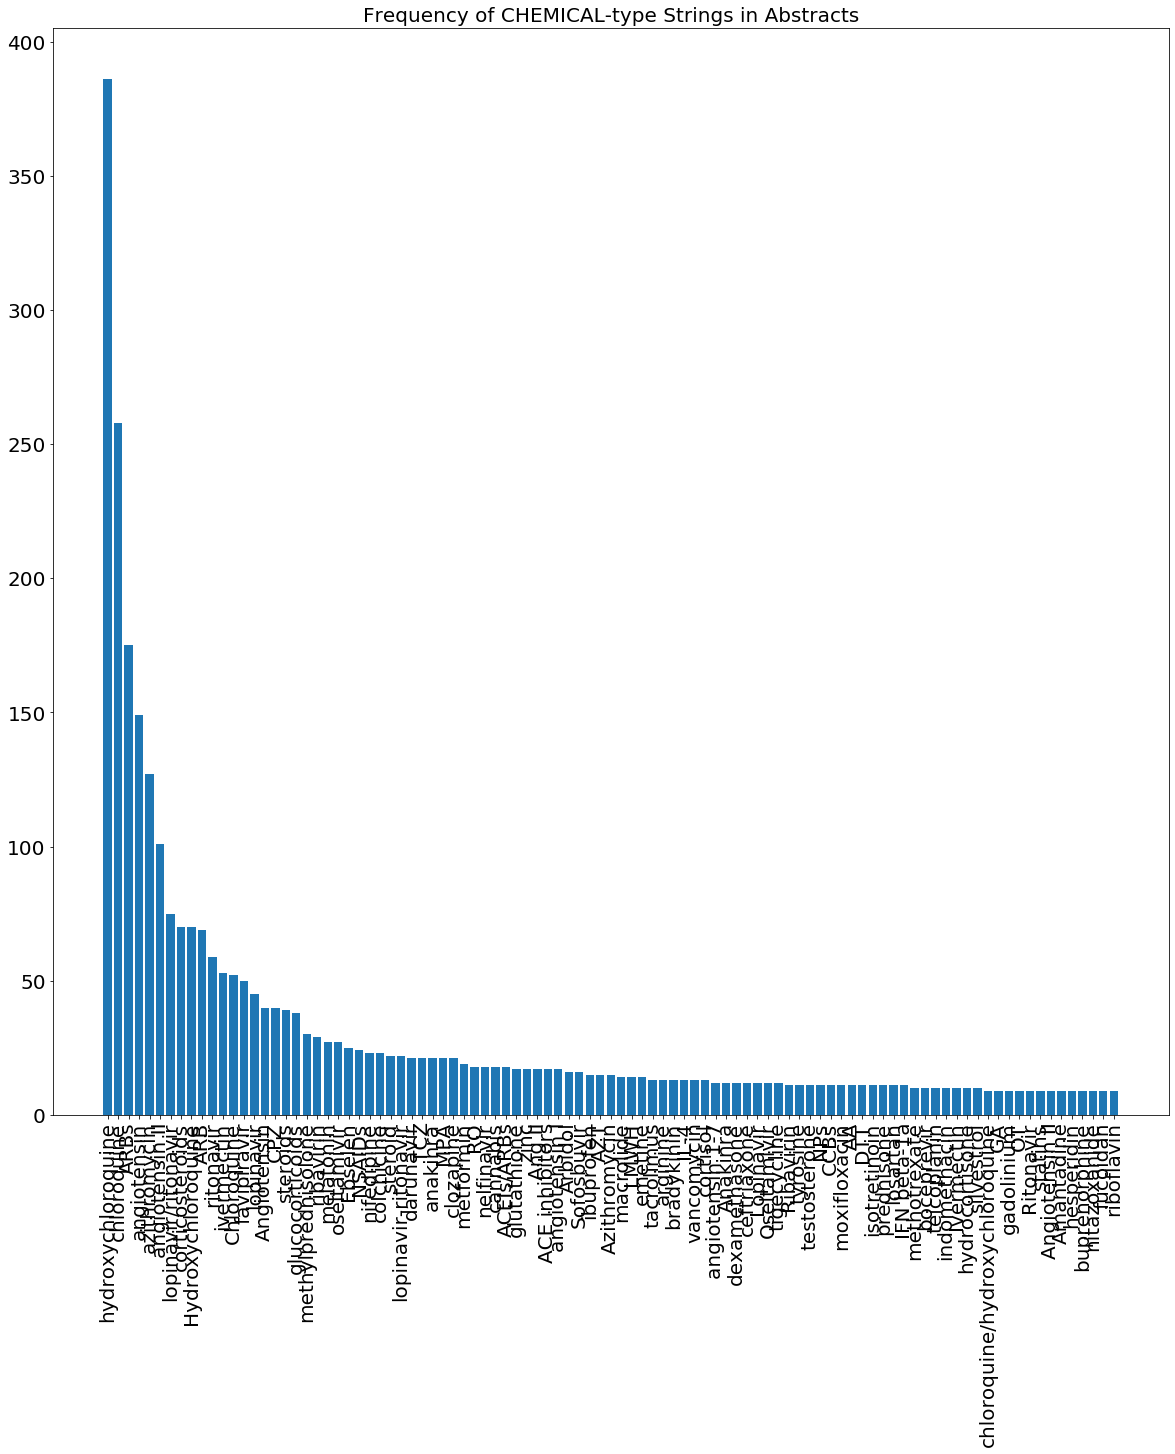

In [47]:
BLACKLIST = {
 'ACE2s',
 '2019-nCoV',
 '95%CI',
 'ACE2-Fc',
 'AMB',
 'AMI',
 'AMK',
 'AOM',
 'AST-045',
 'AST-N041',
 'ATP',
 'BPO3-P',
 'Betacoronavirus',
 'CAP',
 'CAZ',
 'CC',
 'CIP',
 'CP',
 'CLAVE',
 'COVID-2019',
 'CR3022',
 'creatinine', 
 'CTX',
 'CTX-M',
 'CoV-2',
 'DES',
 'DHPG',
 'DIP',
 'E2',
 'ESBL',
 'Enterobacteriaceae',
 'FASTA',
 'FCA',
 'FCS',
 'FOS',
 'GEN',
 'GM',
 'HK',
 'HPDI',
 'IFR',
 'IM',
 'IVA',
 'JA',
 'KLK13',
 'LA',
 'LPV/r',
 'LYM%',
 'La',
 'LcS',
 'Li',
 'MERS-CoV.',
 'MICs',
 'Metapneumovirus',
 'Médecine',
 'NAL',
 'NCP',
 'NG',
 'NLR',
 'NO',
 'NOR',
 'NP',
 'NS7b',
 'OC',
 'OFL',
 'OP',
 'Prefixes',
 'Résumé',
 'S.',
 'SARS-CoV-2',
 'SARS-COV-2',
 'SARS-Cov2',
 'SARS-CoV2',
 'SARS-CoV-2 infection',
 'SARS-CoV-2 infections',
 'SARS-CoV-2 pneumonia',
 'SARS-CoV.',
 'SARS-Cov-2',
 'SARS-related',
 'SGC7901',
 'SHV',
 'SP',
 'Sarbecovirus',
 'Se',
 'TCM',
 'TCR',
 'TCB',
 'TGEV',
 'TOB',
 'TSL-EO',
 'Texte',
 'VME',
 'VP',
 'WeChat',
 'ZJ01',
 '[ST]A',
 'alcohol',
 'amino acid',
 'amino acids',
 'aminoglycosides',
 'bat-SL-CoVZXC21',
 'betacoronavirus',
 'cholesterol',
 'coronavirus',
 'des cas',
 'https://doi.org/10',
 'infector-infectee',
 "l'origine",
 'lactate',
 'lockdowns',
 'na',
 'nucleic acid',
 'nucleic acids',
 'nucleotide',
 'NBCZone',
 'oxygen',
 'quinolones',
 'rinitis',
 'self-imposed',
 'sodium',
 'smoking',
 'β-coronavirus',
 '℃',
 'vitamin D',
 'K',
 'glucose',
 'extract',
 'São Paulo',
 'IMV',
 'Facebook',
 'PPE',
 'hydrogen peroxide',
 'NaCl',
 'NA',
 'nicotine',
 'MSCs',
 'self-isolate',
 'NIV',
 'bilirubin',
 'coronavirus 2019',
 'hydrogen',
 'triphosphate',
 'spine',
 'troponin',
 'PHE',
 'glycerol',
 'LU',
 'CO2',
 'Vitamin D',
 'ethanol',
 'alanine',
 'aspartate',
 'iron',
 'nucleoside',
 'CSR',
 'NPS',
 'sgRNAs',
 'NO2',
 'SM',
 'AZ',
 'lithium',
 'K E Y W O R D S',
 'LU',
 'LAMP',
 'Sars-CoV-2',
 'SOC',
 'IPC',
 'nitric oxide',
 'App',
 'Cmax',
 'potassium',
 'SHM',
 'carbon',
 'AM',
 'heparan sulfate',
 'AMR',
 'high-dose',
 'sanitizer',
 'RTV',
 'FiO',
 'NAD',
 'DMSO',
 'oxytocin',
 'quercetin',
 '2D:4D',
 'SA',
 'DG',
 'appetite',
 'Ozone',
 'chlorine',
 'HCoV-229E',
 'Des',
 'Tc-DTPA',
 'glycine',
 'vasopressors',
 'Th17',
 'Tracker',
 'SARSr-CoV',
 'ICG',
 'coronavirus',
 'Lockdowns',
 'Vaccine',
 'ABA',
 'syndrome-coronavirus',
 'NEU',
 'leptin',
 'phosphate',
 'hydrogen bonds',
 'UVB',
 'TM',
 'HA',
 'luteolin',
 'CD8',
 'UVI',
 'S. epidermidis',
 'CEP',
 'counterhate',
 'ozone',
 'H2O2',
 'coronavirus 2',
 'SNP',
 'HCQ',
 'CQ',
 'ACEI/ARB',
 'ACEi',
 'heparin',
 'ACEI',
 'ACEIs',
 'creatine'
    }


def count_chemical_ents(df):
    ent_str = []
    for i, row in df.iterrows():
        if row.abstract_doc:            
            for ent in row.abstract_doc.ents:
                if ent.label_ == 'CHEMICAL':
                    ent_str.append(row.abstract_doc[ent.start:ent.end].text)
            
    filtered = [e for e in Counter(ent_str).most_common() if e[1] > 8 and e[0] not in BLACKLIST]
    return dict(filtered)

counts = count_chemical_ents(df_with_matches)
print('Count Frequencies\n')
print(counts)

plt.figure(figsize=(20,20))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xticks(rotation=90)
plt.title('Frequency of CHEMICAL-type Strings in Abstracts', fontsize=20)
plt.bar(counts.keys(), counts.values())

# Simple Concordance Visualiser
Helps to compile the above blacklist as well as see contexts in which the above drug names appear.

In [41]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.core.display import HTML

HTML_WRAPPER = """<div style="overflow-x: auto; border: 1px solid #e6e9ef; border-radius: 0.25rem; padding: 1rem; margin-bottom: 2.5rem">{}</div>"""
BEGIN_ENTITY = """<mark class="entity" style="background: lightpink; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">"""
END_ENTITY = """</mark>"""

def match_to_concordance_html(match, doc, window_size=15):
    _, start, end = match
    concordance_start = max(start - window_size, 0)
    concordance_end = min(end + window_size, len(doc))
    return doc[concordance_start:start].text + BEGIN_ENTITY + doc[start:end].text + END_ENTITY + doc[end:concordance_end].text + '</br></br>'

@interact_manual
def show_articles_more_than(column='abstract_doc', query='darunavir'):
    matcher = Matcher(nlp.vocab)
    matcher.add("query", None, [{'LEMMA': w.lemma_} for w in nlp(query)])
    result = []
    html_str = ''
    for doc in df_with_matches[column]:
        if not doc:
            continue
        matches = matcher(doc)
        for match in matches:
            html_str += match_to_concordance_html(match, doc)
    return display(HTML(HTML_WRAPPER.format(html_str + ''))) ##

interactive(children=(Text(value='abstract_doc', description='column'), Text(value='darunavir', description='q…

# Organise matches by Drugs/Therapeutics
A list of drugs/therapeutics that are relevant in the context of COVID-19 were compiled. Now, we can dive deeper into the contexts these drugs appear in.

To this end, we match words that indicate the context of the drug mention:
* drug is in an **idea stage** (e.g. 'darunavir could be useful against COVID-19')
* drug is in a **trial stage** (e.g. 'lopinavir is currently being trialled')
* drug is in **usage stage** (e.g. 'patients are being treated with ritonavir')

These 'indicator' words are marked as additional entities in context.

In [42]:
def doc_id_to_link(doc_id, df_meta, df_data):
    rows = df_meta[df_meta.sha == doc_id]
    if rows.empty:
        return 'UNKNOWN URL AND TITLE'
    url = rows.iloc[0].url
    title = rows.iloc[0].title
    if url and title:
        return '<a href="{}">'.format(url) + title + '</a>'
    elif title:
        return title
    elif url:
        return '<a href="{}">'.format(url) + 'UNKNOWN TITLE' + '</a>'
    else:
        return 'UNKNOWN URL AND TITLE'

def chemical_df(chemicals, df_data, df_meta):
    rows = []    
    for chem in chemicals:
        chem_row = {
            'chemical_name': chem,
            'chemical': [],
            'trials': [],
            'usages': [],
            'ideas': []
        }
        matcher = Matcher(nlp.vocab)
        matcher.add("query", None, [{'LEMMA': w.lemma_} for w in nlp(chem)])
        for i, row in df_data.iterrows():
            chem_matches = matcher(row.abstract_doc)
            for chem_match in chem_matches:
                chem_row['chemical'].append((row.doc_id, chem_match[1], chem_match[2]))
                for trial_match in row.abstract_trial_matches:
                    if abs(trial_match[1] - chem_match[1]) < 15:
                        chem_row['trials'].append((row.doc_id, trial_match[0], trial_match[1]))
                for usage_match in row.abstract_usage_matches:
                    if abs(usage_match[1] - chem_match[1]) < 15:
                        chem_row['usages'].append((row.doc_id, usage_match[0], usage_match[1]))
                for idea_match in row.abstract_idea_matches:
                    if abs(idea_match[1] - chem_match[1]) < 15:
                        chem_row['ideas'].append((row.doc_id, idea_match[0], idea_match[1]))
        rows.append(chem_row)
    return pd.DataFrame(rows)
        
    
df_chemical = chemical_df(list(counts.keys()), df_with_matches, df_meta)
df_chemical.head(10)

,chemical_name,chemical,trials,usages,ideas
0,hydroxychloroquine,"[(7ff99de4d85558cfa209e25767e5b028728bab90, 68...","[(93669fa532a12d5f0d80a1449c05bfbccf04d342, 33...","[(7ff99de4d85558cfa209e25767e5b028728bab90, 64...","[(7ff99de4d85558cfa209e25767e5b028728bab90, 73..."
1,chloroquine,"[(7ff99de4d85558cfa209e25767e5b028728bab90, 66...","[(93669fa532a12d5f0d80a1449c05bfbccf04d342, 33...","[(7ff99de4d85558cfa209e25767e5b028728bab90, 64...","[(7ff99de4d85558cfa209e25767e5b028728bab90, 73..."
2,ARBs,"[(d1ac495575a4d87477fa1371b141da03864c4cd5, 27...","[(d1ac495575a4d87477fa1371b141da03864c4cd5, 35...","[(d1ac495575a4d87477fa1371b141da03864c4cd5, 38...","[(d1ac495575a4d87477fa1371b141da03864c4cd5, 39..."
3,angiotensin,"[(2893afcb9dd20835e62e422a2db8f524dc89ae2e, 23...","[(9cdceb3cf6324b569f5b4cda124a427648f082c4, 23...","[(d1ac495575a4d87477fa1371b141da03864c4cd5, 26...","[(9d3f0464442d81e1c89b16169a9b67964a10a670, 21..."
4,azithromycin,"[(0cf16e6ae20cb6ce1f61f4b0e2c466882d61d084, 12...","[(b694888d27880c407c0001df68fe7055a565f2bf, 15...","[(0cf16e6ae20cb6ce1f61f4b0e2c466882d61d084, 5,...","[(e8378ec07443ac458dd0aa00afbdb43b9ad3d923, 43..."
5,angiotensin II,"[(d1ac495575a4d87477fa1371b141da03864c4cd5, 27...","[(635aceae8dddc3615d93182a7ea3cd8a76b26bb7, 1,...","[(d1ac495575a4d87477fa1371b141da03864c4cd5, 26...","[(635aceae8dddc3615d93182a7ea3cd8a76b26bb7, 24..."
6,heparin,"[(9f88c5a35657c952e7da4575732f5ee12f5dc85e, 68...","[(9f88c5a35657c952e7da4575732f5ee12f5dc85e, 63...","[(9f88c5a35657c952e7da4575732f5ee12f5dc85e, 70...","[(9f88c5a35657c952e7da4575732f5ee12f5dc85e, 59..."
7,ACEIs,"[(494913c577d051e54e07c4c5afe82793ef98ef97, 16...","[(494913c577d051e54e07c4c5afe82793ef98ef97, 17...","[(494913c577d051e54e07c4c5afe82793ef98ef97, 14...","[(494913c577d051e54e07c4c5afe82793ef98ef97, 16..."
8,lopinavir/ritonavir,"[(b0043d7e0cd1b41ff48b77a7d0cf2cc97ae57a63, 12...","[(db9b1a30d2e47bbf1c48accca3c3d87eefd69f8b, 26...","[(b0043d7e0cd1b41ff48b77a7d0cf2cc97ae57a63, 10...","[(dda279eb76f13d551fa81fe4eaa4526b6314b9c9, 21..."
9,corticosteroids,"[(d3744e7581b12fe33a93e21e89b5da988b790b4b, 17...","[(d3744e7581b12fe33a93e21e89b5da988b790b4b, 24...","[(d3744e7581b12fe33a93e21e89b5da988b790b4b, 16...","[(17de28ebcf5e84031aec3acd10e45e62bc14f594, 27..."


## Code for highlighting  the texts

In [43]:
LABEL_TO_COLOUR = {
    'chemical': 'lightorange',
    'trials': 'lightpink',
    'usages': 'lightgreen',
    'ideas': 'lightblue'
}
BEGIN_ENTITY = """<mark class="entity" style="background: {}; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">"""
END_ENTITY_WITH_SUBSCRIPT = """<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">{}</span>\n</mark>"""

def get_ents_by_doc_id(row):
    contexts={'chemical', 'trials', 'usages', 'ideas'}
    ents_by_doc_id = {}
    for c in contexts:
        for doc_id, start, end in row[c]:
            entry = (start, end, c)
            if doc_id not in ents_by_doc_id:
                ents_by_doc_id[doc_id] = [entry]
            else:
                ents_by_doc_id[doc_id].append(entry)
    return ents_by_doc_id

@interact
def show_articles_for_chemical(chemical=list(counts.keys())):
    row = df_chemical[df_chemical['chemical_name'] == chemical].iloc[0]
    ents_by_doc_id = get_ents_by_doc_id(row)
    html = ''
    for doc_id, ents in ents_by_doc_id.items():
        doc = df_with_matches[df_with_matches.doc_id == doc_id].iloc[0].abstract_doc
        sorted_ents = sorted(set(ents))
        doc_html = doc_id_to_link(doc_id, df_meta, df_covid19) + '</br></br>' 
        prev_end = 0
        for start, end, label in sorted_ents:
            doc_html += doc[prev_end:start].text
            doc_html += ' ' + BEGIN_ENTITY.format(LABEL_TO_COLOUR[label]) + doc[start:end].text + END_ENTITY_WITH_SUBSCRIPT.format(label) + ' '
            prev_end = end
        doc_html += doc[end:].text + '</br></br>'
        html+=doc_html
        

    return display(HTML(html))

interactive(children=(Dropdown(description='chemical', options=('hydroxychloroquine', 'chloroquine', 'ARBs', '…


# Clustering the cited compounds 
Top cited compounds are grouped into in clusters according to their molecular structure.\
**PCA** was used to reduce dimensionality and create a cluster with **K-means** algorithm.

In [48]:
# function to draw the molecule
def drawit(m,p,confId=-1):
    mb = Chem.MolToMolBlock(m,confId=confId)
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()
p = py3Dmol.view(width=400,height=400)

In [49]:
# get the top drugs most mentioned
listchemicals = df_chemical.chemical_name.replace('lopinavir/ritonavir', 'lopinavir').head(25)
listchemicals

0     hydroxychloroquine
1            chloroquine
2                   ARBs
3            angiotensin
4           azithromycin
5         angiotensin II
6                heparin
7                  ACEIs
8              lopinavir
9        corticosteroids
10    Hydroxychloroquine
11                   ARB
12             ritonavir
13            ivermectin
14           Chloroquine
15           favipiravir
16             lopinavir
17              creatine
18           Angiotensin
19                   CPZ
20              steroids
21                  ACEI
22       glucocorticoids
23    methylprednisolone
24             ribavirin
Name: chemical_name, dtype: object

In [50]:
# Create clusters
listMols2 = []
listValids = []

for i in range(len(listchemicals)):
    try:
        productName = listchemicals[i]
        
        # Initiate Chembl database client
        molecule = new_client.molecule
        # get the moelcule id
        molecule_chembl_id = molecule.search(productName)[0]['molecule_chembl_id']
        res = molecule.get(molecule_chembl_id)
        # return smile format molecular structure
        smileStruct = res['molecule_structures']['canonical_smiles']
        # converto to mol format
        m = Chem.MolFromSmiles(smileStruct)
        m = Chem.AddHs(m)
        listMols2.append(m)
        listValids.append(productName)
      
    except Exception as e:
        print(f'\nSorry, impossible to create structure for {productName}.')
        
        
# generate fingeprints: Morgan fingerprint with radius 2
n_dimensions = 300
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, n_dimensions) for m in listMols2]
# Convert to numpy array
np_fps = np.asarray(fps)

############# PCA decomposition (n=3)  #######################
centers = [[1, 1], [-1, -1], [1, -1]]
X = np_fps
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)
df2 = pd.DataFrame(X ,columns=['principal_component_1','principal_component_2','principal_component_3'])
df2['names'] = pd.DataFrame(listValids)

############# Kmeans clusters  #######################
kmeansmodel = KMeans(n_clusters=8).fit(df2[df2.columns[0:3]])
labelKmeans = kmeansmodel.labels_.astype(float)
df2['cluster'] = labelKmeans


Sorry, impossible to create structure for heparin.

Sorry, impossible to create structure for ACEIs.

Sorry, impossible to create structure for ACEI.


In [51]:
# Remove duplicated compounds
df2 = df2.drop_duplicates(subset=['principal_component_1','principal_component_2','principal_component_3'])
df2.sort_values(by=['cluster'])

,principal_component_1,principal_component_2,principal_component_3,names,cluster
0,-3.484431,-2.707640,-1.438906,hydroxychloroquine,0.0
1,-3.406472,-3.025651,-1.023241,chloroquine,0.0
18,-0.143202,3.612690,-1.818896,steroids,1.0
11,0.651226,3.331910,-3.354220,ivermectin,1.0
4,0.277512,2.830664,-2.272125,azithromycin,1.0
6,0.883404,1.038051,1.766558,lopinavir,2.0
10,0.893482,-0.456562,1.252582,ritonavir,2.0
3,5.158325,-2.780443,-1.047179,angiotensin,3.0
5,5.311154,-2.529058,-0.858391,angiotensin II,3.0
2,-0.164535,0.239158,4.725610,ARBs,4.0


In [52]:
# Gabarge collector to liberate memory
gc.collect()

142

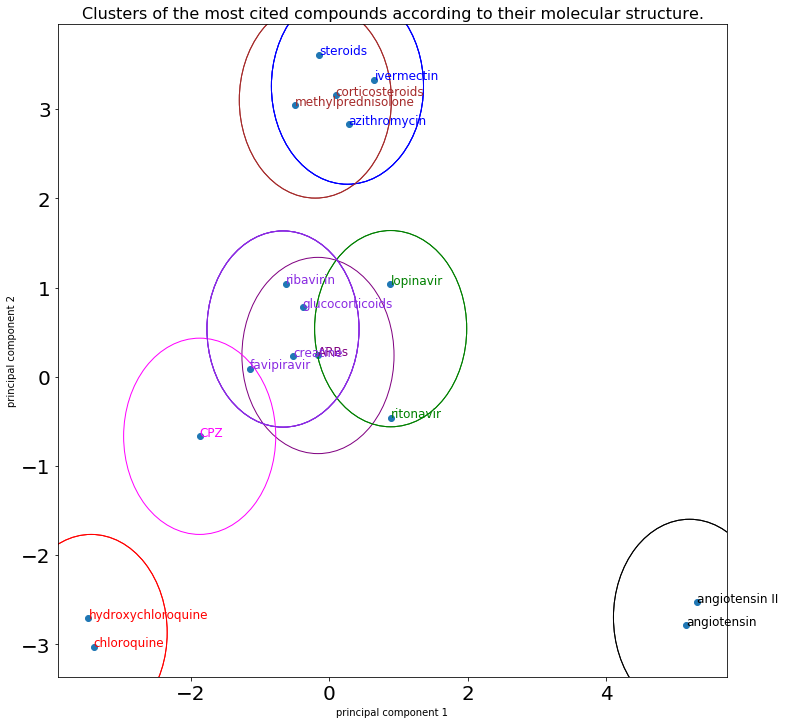

In [53]:
############# Scatter plot  #######################
import matplotlib.patches as mpatches

centroids  = kmeansmodel.cluster_centers_

def randrange(n, vmin, vmax):
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

xs = df2.principal_component_1
ys = df2.principal_component_2
names = df2.names
cluster = df2.cluster
ax.scatter(xs, ys)
radius = 1.1

for x,y,names,cluster in zip(xs,ys,names,cluster):
    label = names
    if cluster == 0:
        ax.text(x, y, label, fontsize=12, color='red')
        art = mpatches.Circle(centroids[0],radius, edgecolor='r',fill=False)
        ax.add_patch(art)
    if cluster == 1:
        ax.text(x, y, label,fontsize=12, color='blue')
        art = mpatches.Circle(centroids[1],radius, edgecolor='blue',fill=False)
        ax.add_patch(art)        
    if cluster == 2:
        ax.text(x, y, label, fontsize=12, color='green')
        art = mpatches.Circle(centroids[2],radius, edgecolor='green',fill=False)
        ax.add_patch(art)        
    if cluster == 3:
        ax.text(x, y, label, fontsize=12, color='black') 
        art = mpatches.Circle(centroids[3],radius, edgecolor='black',fill=False)
        ax.add_patch(art)        
    if cluster == 4:
        ax.text(x, y, label, fontsize=12, color='purple')
        art = mpatches.Circle(centroids[4],radius, edgecolor='purple',fill=False)
        ax.add_patch(art)        
    if cluster == 5:
        ax.text(x, y, label, fontsize=12, color='blueviolet') 
        art = mpatches.Circle(centroids[5],radius, edgecolor='blueviolet',fill=False)
        ax.add_patch(art)        
    if cluster == 6:
        ax.text(x, y, label, fontsize=12, color='brown') 
        art = mpatches.Circle(centroids[6],radius, edgecolor='brown',fill=False)
        ax.add_patch(art)        
    if cluster == 7:
        ax.text(x, y, label, fontsize=12, color='magenta')  
        art = mpatches.Circle(centroids[7],radius, edgecolor='magenta',fill=False)
        ax.add_patch(art)        
    
      

ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.title('Clusters of the most cited compounds according to their molecular structure.', loc='center', pad=None, fontSize=16)
plt.show()

We can clearly see the separation of compounds groups from the results obtained.

Public References:  (In case of doubt to which chemical class a certain compound belongs, you can consult the public database PubChem )   
https://pubchem.ncbi.nlm.nih.gov  
https://pubchem.ncbi.nlm.nih.gov/compound/392622  
https://pubchem.ncbi.nlm.nih.gov/compound/5755  
https://pubchem.ncbi.nlm.nih.gov/compound/213039  
https://pubchem.ncbi.nlm.nih.gov/compound/70678539  
https://pubchem.ncbi.nlm.nih.gov/compound/5479537   
https://pubchem.ncbi.nlm.nih.gov/compound/Amphotericin%20B
https://pubchem.ncbi.nlm.nih.gov/compound/121304016

# Conclusion

This notebook present a technique to analyse the documents provided in search of relevant information about drugs being developed or tested.   

A method was developed to find the relevant files among those provided in the challenge.

Subsequently, a routine was developed whose objective is to find the words of interest as well as highlight them in the text and evaluate the context in which they are found. 

All of this allows the user to quickly and efficiently search various files of interest.

It was also evaluated the correlation of the molecular structure of the most mentioned compounds among themselves, through clustering.


With the work it was possible to reach the following conclusions:

* Several articles cite therapeutics with the use of drugs from different classes, such as antiretroviral protease inhibitors, corticosteroids, polyene antibiotics, glycosaminoglycans heparan sulfate, proteases and aminoquinoline derivatives.
* There are 23 ongoing clinical trialsTRIALS in China. Chloroquine seems to be effective in limiting the replication of SARS-CoV-2 (virus causing COVID-19) in vitro.(https://www.sciencedirect.com/science/article/pii/S0883944120303907?via%3Dihub)
* Chloroquine was a highly effective treatment for falciparum malaria in The Gambia. High-grade resistance will soon preclude the use of chloroquine in severe malaria.(https://www.thelancet.com/journals/lancet/article/PII0140-6736(92)91645-O/fulltext) 
* (Chymo)trypsin-like serine fold proteases belong to the serine/cysteine proteases found in eukaryotes, prokaryotes, and viruses. For that reason, their catalytic activity is carried out using a triad of amino acids, a nucleophile, a base, and an acid. For this superfamily of proteases, they propose the existence of a universal 3D structure comprising 11 amino acids near the catalytic nucleophile and base -Nucleophile-Base Catalytic Zone (NBCZone).(https://www.sciencedirect.com/science/article/pii/S0141813019386854?via%3Dihub)
* The structure models of two severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) proteases, coronavirus endopeptidase C30 (CEP_C30) and papain like viral protease (PLVP), were built by homology modeling. Ritonavir, lopinavir and darunavir were then docked to the models, respectively, followed by energy minimization of the protease-drug complexes. In the simulations, ritonavir can bind to coronavirus endopeptidase C30 (CEP_C30)  most suitably, and induce significant conformation changes of CEP_C30; lopinavir can also bind to CEP_C30 suitably, and induce significant conformation changes of CEP_C30; darunavir can bind to PLVP suitably with slight conformation changes of PLVP. It is suggested that the therapeutic effect of ritonavir and lopinavir on COVID-19 may be mainly due to their inhibitory effect on CEP_C30, while ritonavirL may have stronger efficacy ; the inhibitory effect of darunavir on SARS-CoV-2 and its potential therapeutic effect may be mainly due to its inhibitory effect on PLVP. (https://www.biorxiv.org/content/10.1101/2020.01.31.929695v2)
* A total of 26 patients received intravenous administration of methylprednisolone with a dosage of 1-2mg/kg/d for 5-7 days, while the remaining patients not. The average number of days for body temperature back to the normal range was significantly shorter in patients with administration of methylprednisolone when compared to those without administration of methylprednisolone (2.06±0.28 vs. 5.29±0.70, P=0.010). The patients with administration of methylprednisolone had a faster improvement of SpO2, while patients without administration of methylprednisolone had a significantly longer interval of usingUSAGES supplemental oxygen therapy (8.2days[IQR 7.0-10.3] vs. 13.5days(IQR 10.3-16); P<0.001). In terms of chest CT, the absorption degree of the focus was significantly better in patients with administration of methylprednisolone. Our dataTRIALS indicate that in patients with severe COVID-19 pneumonia, early, lowdose and short-term application of corticosteroid was associated with a faster improvement of clinical symptoms and absorption of lung focus. (https://www.medrxiv.org/content/10.1101/2020.03.06.20032342v1)
*  It was studied the interaction between the SARS-CoV-2 Spike S1 protein receptor binding domain (SARS-CoV-2 S1 RBD) and heparin. The data demonstrate an interaction between the recombinant surface receptor binding domain and the polysaccharide. This has implications for the rapid development of a first-line therapeutic by repurposing heparin and for next-generation, tailor-made, GAG-based antivirals.(https://www.biorxiv.org/content/10.1101/2020.02.29.971093v1)



The results show that the technique can be used to gain important insights into the about drugs and therapeutics related to coronavirus pandemic, in an agile way and without having to read thousands of full papers.   

 
## Pros and cons

About the technique used, we can highlight the ease and speed of obtaining the required information. 

As cons, depending on the number of files to be evaluated, the execution of the algorithm can take a while.